In [69]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pandas_profiling
%matplotlib inline  

# csv 형식으로 된 데이터 파일을 읽어옵니다. 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'data set은 {train.shape[1]} 개의 feature를 가진 {train.shape[0]} 개의 데이터 샘플로 이루어져 있습니다.')

# 데이터의 최상단 5 줄을 표시합니다.
train.head()

data set은 11 개의 feature를 가진 1015 개의 데이터 샘플로 이루어져 있습니다.


id                          title  odometer location    isimported  \
0   0                   Toyota RAV 4     18277   Lagos   Foreign Used   
1   1            Toyota Land Cruiser        10    Lagos          New    
2   2  Land Rover Range Rover Evoque     83091    Lagos  Foreign Used   
3   3                   Lexus ES 350     91524    Lagos  Foreign Used   
4   4                   Toyota Venza     94177    Lagos  Foreign Used   

           engine transmission    fuel  paint  year    target  
0  4-cylinder(I4)    automatic  petrol    Red  2016  13665000  
1  4-cylinder(I4)    automatic  petrol  Black  2019  33015000  
2  6-cylinder(V6)    automatic  petrol    Red  2012   9915000  
3  4-cylinder(I4)    automatic  petrol   Gray  2007   3815000  
4  6-cylinder(V6)    automatic  petrol    Red  2010   7385000

In [70]:
print(train.shape, test.shape)

(1015, 11) (436, 10)


In [47]:
pr = train.profile_report()
pr.to_file('pr_report.html')
pr

Export report to file: 100%|█████████████████████| 1/1 [00:00<00:00, 276.23it/s]


In [71]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [72]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    print(label_maps)
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

le = make_label_map(train)
train = label_encoder(train, le)
train.head()

{'title': {'unknown': 0, 'Toyota RAV 4': 1, 'Toyota Land Cruiser': 2, 'Land Rover Range Rover Evoque': 3, 'Lexus ES 350': 4, 'Toyota Venza': 5, 'Toyota Corolla': 6, 'Land Rover Range Rover Sport': 7, 'Pontiac Vibe': 8, 'Toyota Tacoma': 9, 'Lexus RX 350': 10, 'Ford Escape': 11, 'Honda Civic': 12, 'Volvo XC90': 13, 'BMW 750': 14, 'Infiniti JX': 15, 'Honda Accord': 16, 'Mercedes-Benz ML 350': 17, 'Toyota Camry': 18, 'Hyundai Azera': 19, 'Lexus GX 460': 20, 'BMW 325': 21, 'Toyota Sienna': 22, 'Honda Fit': 23, 'Honda CR-V': 24, 'Hyundai Tucson': 25, 'Ford Transit': 26, 'Jaguar XJ8': 27, 'BMW X6': 28, 'Mercedes-Benz C 300': 29, 'Mitsubishi Galant': 30, 'Mercedes-Benz GL 450': 31, 'Lexus RX 300': 32, 'Toyota Highlander': 33, 'Mitsubishi CANTER PICK UP': 34, 'Nissan Titan': 35, 'Lexus IS 250': 36, 'Mercedes-Benz 200': 37, 'Toyota Sequoia': 38, 'Ford Explorer': 39, 'Hyundai ix35': 40, 'Mack CH613 CONVENTIONAL CAB': 41, 'Lexus CT 200h': 42, 'Lexus LX 570': 43, 'Toyota Avensis': 44, 'Toyota 4-Run

id  title  odometer  location  isimported  engine  transmission  fuel  \
0   0      1     18277         1           1       1             1     1   
1   1      2        10         2           2       1             1     1   
2   2      3     83091         2           1       2             1     1   
3   3      4     91524         2           1       1             1     1   
4   4      5     94177         2           1       2             1     1   

   paint  year    target  
0      1  2016  13665000  
1      2  2019  33015000  
2      1  2012   9915000  
3      3  2007   3815000  
4      1  2010   7385000

In [73]:
X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 중고차 가격 추출

In [74]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.25) #25프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

In [75]:
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (761, 11)
검증할 val 셋 :  (254, 11)


In [76]:
X_train = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
Y_train = train_data.target #training 데이터에서 target 추출

X_val = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
Y_val = val_data.target #validation 데이터에서 target 추출

In [77]:
import shap
model = XGBRegressor()
model.fit(X_train, Y_train)
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
#force plot 특정 데이터 하나 또는 전체 데이터에 대해 Shapley value를 1차원으로 나타냄
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

자동차 가격에 긍정적인 영향을 끼친것은 빨간색 막대로 year, isimported(현지사용여부)
부정적인 영향을 끼친것은 title, engine, paint, odometer 

In [79]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

전체 데이터에 대한 Shapley value를 누적하여 시각화
빨간색은 예측에 긍정적인 영향 파랑색은 부정적인 영향을 끼침

다음은 dependence_plot을 통한 각 특성의 Shapely value

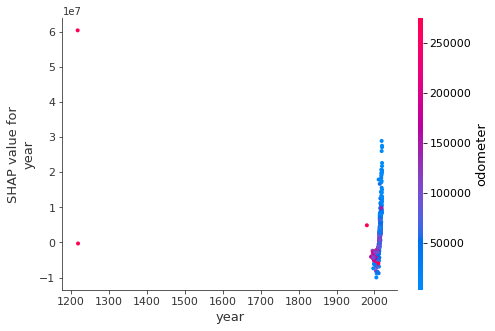

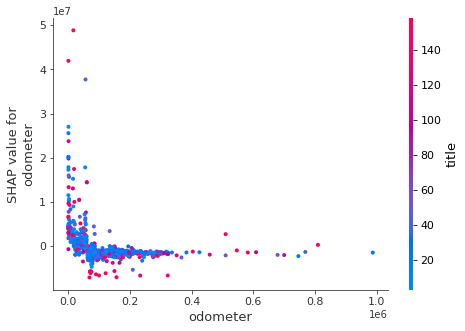

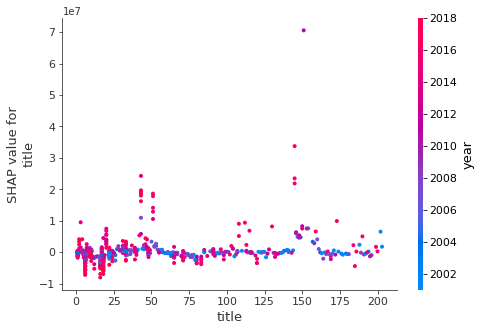

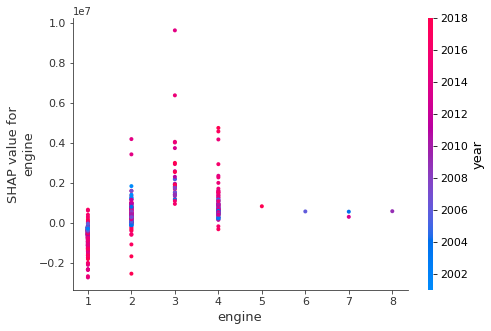

In [85]:
shap.initjs()
#각각의 특성의 Shapley value를 절대값 변환 후 각 특성마다 더함
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# 영향력 top 4 컬럼
for i in range(4):
    shap.dependence_plot(top_inds[i], shap_values, X_train)

x축은 특성 값 y축은 해당 특성의 Shapley value, 오른쪽 y축은 각 특성과의 관계(상호작용 효과)를 나타냄
수직패턴이 나올수록 관계가 존재함

다음은 summary_plot을 이용하여 전체 특성들이 Shapley value 분포에 대해 어떤 영향을 미치는지 시각화함

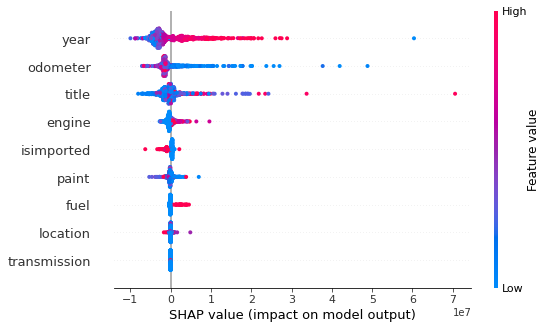

In [86]:
shap.summary_plot(shap_values, X_train)

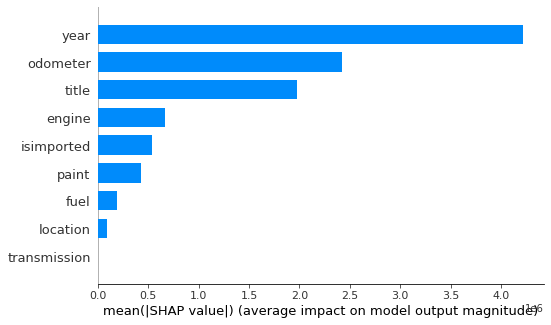

In [87]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

interaction plot 은 각 특성간의 관계(상호작용 효과)를 파악할 수 있음

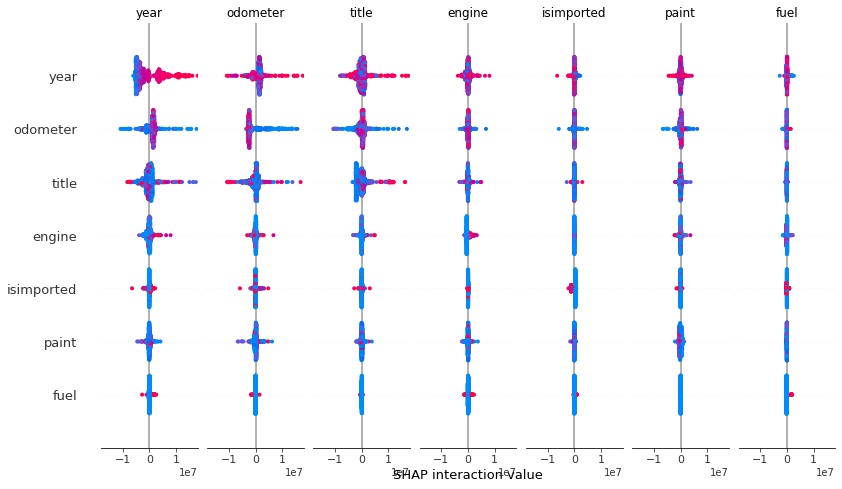

In [88]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

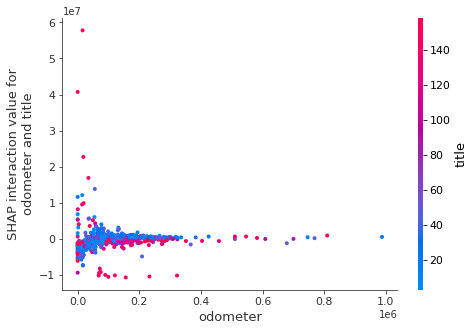

In [92]:
shap.dependence_plot(
    ('odometer', 'title'),
    shap_interaction_values, X_train,
    display_features=X_train
)

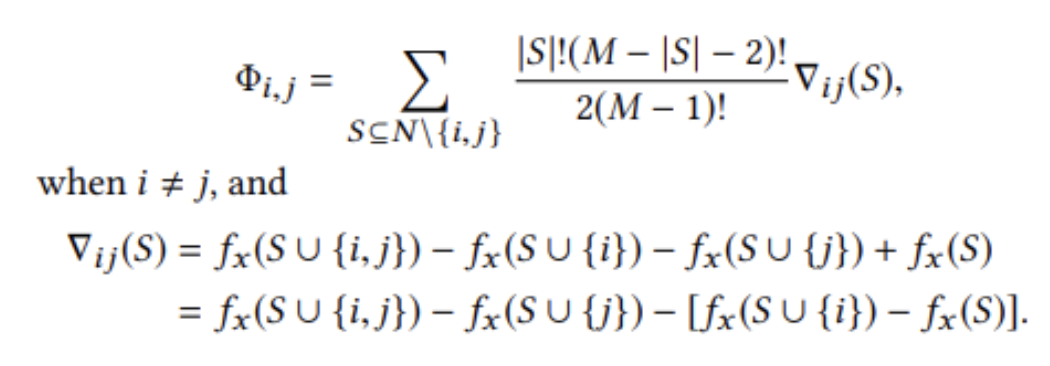